In [1]:
import h5py
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [2]:
f_data = h5py.File("./BikeNYC/NYC14_M16x8_T60_NewEnd.h5")
BikeNYC_date = f_data['date']
BikeNYC_data = f_data['data']
print(f'date: \n{BikeNYC_date[0]}\n shape:{BikeNYC_date.shape} \n in_flow:\n{BikeNYC_data[0][0]} \n out_flow: \n{BikeNYC_data[0][1]}')
print(BikeNYC_data.shape)

date: 
b'2014040101'
 shape:(4392,) 
 in_flow:
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 4. 1. 1. 0. 0.]
 [0. 0. 2. 5. 0. 2. 2. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 1. 3. 1. 4. 2. 0. 0.]
 [0. 3. 3. 6. 3. 0. 0. 0.]
 [0. 2. 6. 5. 5. 0. 0. 0.]
 [0. 6. 3. 8. 1. 0. 0. 0.]
 [0. 2. 0. 2. 0. 0. 0. 0.]
 [3. 4. 5. 0. 1. 0. 1. 0.]
 [0. 2. 2. 1. 0. 0. 2. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1.]] 
 out_flow: 
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 3. 2. 1. 0. 0.]
 [0. 0. 0. 3. 0. 1. 0. 0.]
 [0. 1. 1. 2. 1. 0. 0. 0.]
 [0. 4. 2. 1. 2. 0. 0. 0.]
 [0. 1. 5. 5. 3. 0. 0. 0.]
 [0. 2. 5. 3. 4. 0. 0. 0.]
 [0. 2. 4. 7. 0. 0. 0. 0.]
 [1. 1. 2. 9. 1. 0. 0. 0.]
 [1. 1. 2. 2. 1. 0. 2. 0.]
 [1. 2. 2. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
(4392, 2, 16, 8)


In [27]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(seq.shape[0]- window_size):
        result.append(seq[i: i+window_size])
    result = np.array(result)
    return result

def MLPreshape(set):
    set = set.reshape((set.shape[0],set.shape[1],-1))
    return set

def MLPreshape_inverse(set):
    set = set.reshape((set.shape[0],set.shape[1],16,8))
    return set

data_num = BikeNYC_date.shape[0]
flow_in_num = 0
train_seq = BikeNYC_data[:int(data_num*0.7),flow_in_num,:,:]
validation_seq = BikeNYC_data[int(data_num*0.7):int(data_num*0.8),flow_in_num,:,:]
test_seq = BikeNYC_data[int(data_num*0.8):,flow_in_num,:,:]
print(train_seq.shape,validation_seq.shape,test_seq.shape)

window_size = 7
train_set = sliding_window(train_seq, window_size)
validation_set = sliding_window(validation_seq, window_size)
test_set = sliding_window(test_seq, window_size)
print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

train_set = MLPreshape(train_set)
validation_set = MLPreshape(validation_set)
test_set = MLPreshape(test_set)

print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

(3074, 16, 8) (439, 16, 8) (879, 16, 8)
(3067, 7, 16, 8)
(432, 7, 16, 8)
(872, 7, 16, 8)
(3067, 7, 128)
(432, 7, 128)
(872, 7, 128)


In [28]:
class OutputNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(OutputNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.relu(self.fc2(x))


In [42]:
device = 'cpu'
torch_lstm = nn.LSTM(input_size=16*8, hidden_size=32, num_layers=1, batch_first=True)
output_model = OutputNet(state_dim=32, hidden_dim=64, action_dim=16*8)

In [43]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_lstm.parameters()) + list(output_model.parameters()), lr=0.0001)

In [44]:
#保存打印文件
f = open("./date/1.4torchLSTM.txt", 'a+')

In [41]:
# 这两句只在第二次运行这个框架时运行，是为了重载文件流防止内存溢出。
f.close()
os.remove("./date/1.4torchLSTM.txt")

In [13]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [14]:
def next_batch(data, batch_size):
    data_length = data.shape[0]
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [45]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch
for epoch in range(500):

    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()

        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :6,:], batch[:, -1,:]
        # print(x.unsqueeze(-1).shape)
        out, hidden = torch_lstm(x)  # out: (batch_size, seq_len, hidden_size)
        out = output_model(out[:, -1, :])
        prediction = out  # (batch)
#         print(prediction.shape,label.shape)
        loss = loss_func(prediction, label)
#         print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均loss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)
        train_log.append(loss.detach().cpu().numpy().tolist())

        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)

        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :6,:], batch[:, -1,:]
                out, hidden = torch_lstm(x)  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 1, train_loss 361.269226,Time used 0.009998s
batch 2, train_loss 365.146179,Time used 0.016001s
batch 3, train_loss 429.444946,Time used 0.008999s
batch 4, train_loss 402.518219,Time used 0.007999s
batch 5, train_loss 377.766113,Time used 0.009000s
batch 6, train_loss 397.482452,Time used 0.010001s
batch 7, train_loss 371.128326,Time used 0.031998s
batch 8, train_loss 417.392426,Time used 0.008002s
batch 9, train_loss 388.844055,Time used 0.007999s
batch 10, train_loss 450.744293,Time used 0.008001s
batch 11, train_loss 474.601013,Time used 0.010002s
batch 12, train_loss 457.248138,Time used 0.008999s
batch 13, train_loss 425.259979,Time used 0.007998s
batch 14, train_loss 383.982635,Time used 0.008001s
batch 15, train_loss 419.344727,Time used 0.021000s
batch 16, train_loss 470.692474,Time used 0.008999s
batch 17, train_loss 420.883698,Time used 0.007997s
batch 18, train_loss 357.058868,Time used 0.009001s
batch 19, train_loss 433.963013,Time used 0.006000s
batch 20, train_loss 

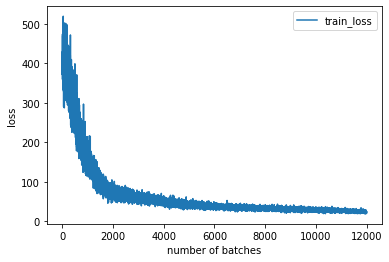

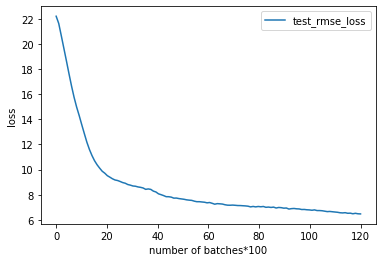

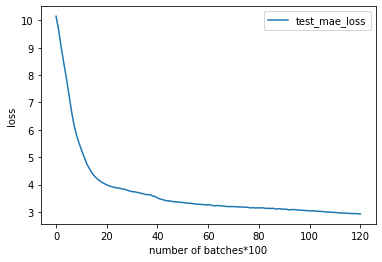

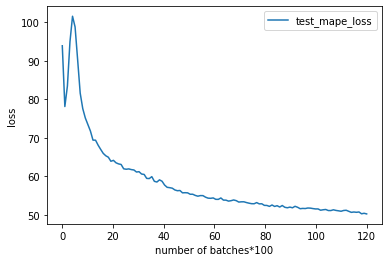

In [46]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtrainloss1.jpg')
plt.show()
#plt.clf()
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmseloss1.jpg')
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmaeloss1.jpg')
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmapeloss1.jpg')
plt.show()

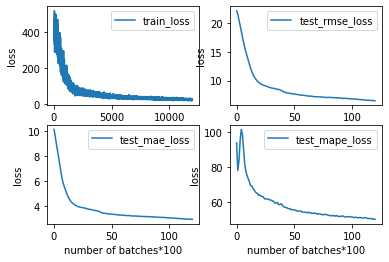

In [48]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.subplot(2, 2, 1)
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 2)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 3)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 4)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/LSTM-4-photo.jpg_32_64_128.jpg')
plt.show()
#plt.clf()